<a href="https://colab.research.google.com/github/EduardoLawson1/Pytorch-Practice/blob/main/Pytorch%20Custom%20Datasets/Pytorch_Custom_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 4 of the Pytorch for DeepLearning Bootcamp from ZTM

This section is for how you use you custom datasets with Pytorch

## 0. Importing Pytorch and set up device agnostic code

In [1]:
import torch
from torch import nn

#Note: Pytorch 1.10.0 + is required
torch.__version__

'2.3.1+cu121'

In [2]:
#setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data
Our dataset is a subset of the Food 101 dataset.
The Food dataset starts with 101 different class and 1000 images per class
Our dataset starts with 3 classes of food and only 10% of the images

In [3]:
import requests
import zipfile
from pathlib import Path

#setuo path to a folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

#if the foldere doesn't exist download it
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"{image_path} doesn't exists... creating one")
  image_path.mkdir(parents=True, exist_ok=True)

#Downloading it
with open(data_path/ "pizza_steak_sushi.zip", "wb") as f:
  requests = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading dataset from github")
  f.write(requests.content)

#unzip it
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("unzipping it")
  zip_ref.extractall(image_path)


data/pizza_steak_sushi doesn't exists... creating one
unzipping it


## 2. Data preparation and data exploration

In [4]:
import os

def walkthrough_dir(dir_path):
  """walks through dir_path returning its content"""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dir_path}")

walkthrough_dir(image_path)


There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi
There are 0 directories and 75 images in data/pizza_steak_sushi
There are 0 directories and 78 images in data/pizza_steak_sushi
There are 0 directories and 72 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi
There are 0 directories and 19 images in data/pizza_steak_sushi
There are 0 directories and 25 images in data/pizza_steak_sushi
There are 0 directories and 31 images in data/pizza_steak_sushi


In [5]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing a image

Let's ride some code to:
1. Get all of the image paths
2. Pick a rando image path using random.choice()
3. Get the image class name using 'pathlib.Path.parent.stem'
4. Open the image with Pillow

Random image path: data/pizza_steak_sushi/train/sushi/424994.jpg
Image class: 424994
Image height: 382
Image width: 512


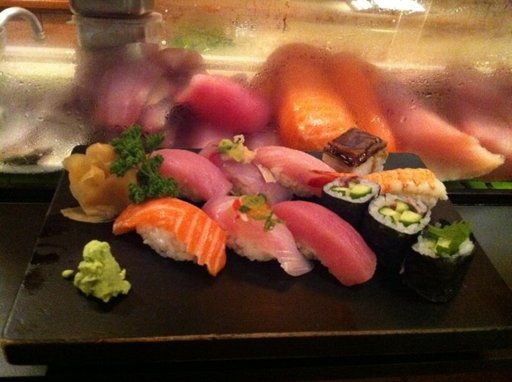

In [6]:
import random
from PIL import Image

#Set seed
#random.seed(42)

# 1. Get the paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a rando image
random_image_path = random.choice(image_path_list)


# 3. Get image class from path name (the class is the name of the directory)
image_class = random_image_path.stem

# 4. OPen image
img = Image.open(random_image_path)

# 5. print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

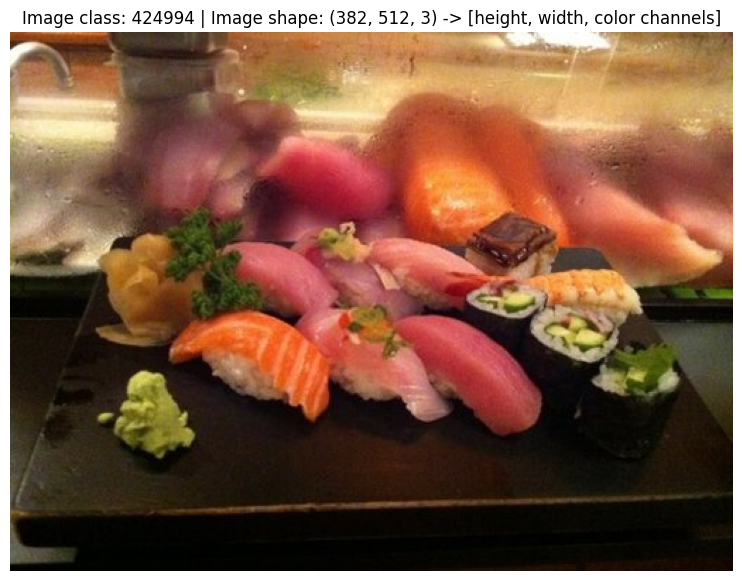

In [7]:
import numpy as np
import matplotlib.pyplot as plt

#Turn the image into an array
img_as_array = np.asarray(img)
#Plot the image with Matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color channels]")
plt.axis(False);

## 3. Transforming data
Before we can use our image data with Pytorch:
1. Turn your target data into tensors
2. Turn it into a `torch.utils.data.Dataset` and a subsequently a `torch.utils.data.DataLoader`



In [8]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torch.vision.transforms`

In [9]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    #turn the image into a torch tensor
    transforms.ToTensor()
  ])
data_transform(img)

tensor([[[0.5176, 0.5725, 0.5961,  ..., 0.5059, 0.5333, 0.5020],
         [0.5961, 0.8118, 0.7176,  ..., 0.5686, 0.5686, 0.5451],
         [0.9176, 0.7098, 0.5333,  ..., 0.6078, 0.5882, 0.5961],
         ...,
         [0.3843, 0.3137, 0.2549,  ..., 0.0471, 0.0431, 0.0431],
         [0.3529, 0.3333, 0.3020,  ..., 0.0706, 0.0706, 0.0667],
         [0.0980, 0.0824, 0.0706,  ..., 0.0824, 0.0863, 0.0784]],

        [[0.2588, 0.3020, 0.3255,  ..., 0.3843, 0.4039, 0.3569],
         [0.4980, 0.7216, 0.5647,  ..., 0.4392, 0.4392, 0.4039],
         [0.9020, 0.6471, 0.4196,  ..., 0.4706, 0.4510, 0.4549],
         ...,
         [0.3765, 0.2902, 0.2314,  ..., 0.0314, 0.0314, 0.0314],
         [0.3529, 0.3216, 0.2824,  ..., 0.0392, 0.0353, 0.0275],
         [0.0980, 0.0824, 0.0667,  ..., 0.0392, 0.0392, 0.0275]],

        [[0.1020, 0.1490, 0.1490,  ..., 0.2118, 0.2471, 0.2431],
         [0.4196, 0.6392, 0.4510,  ..., 0.2667, 0.2667, 0.2549],
         [0.8627, 0.5882, 0.3333,  ..., 0.2784, 0.2549, 0.

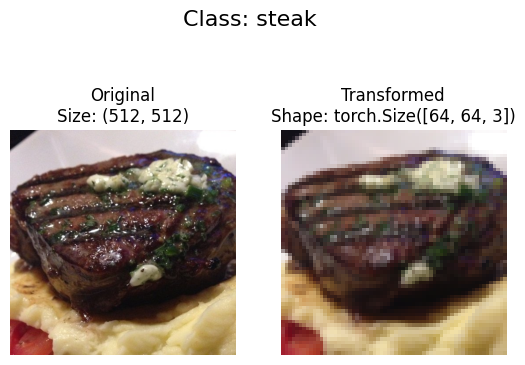

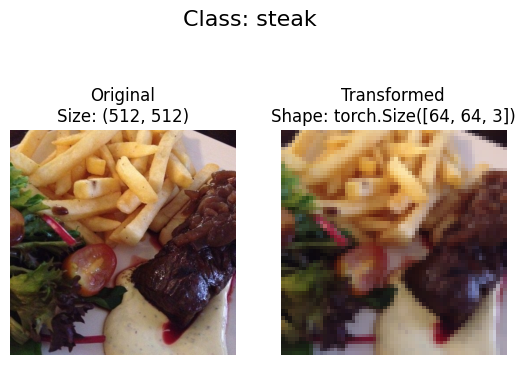

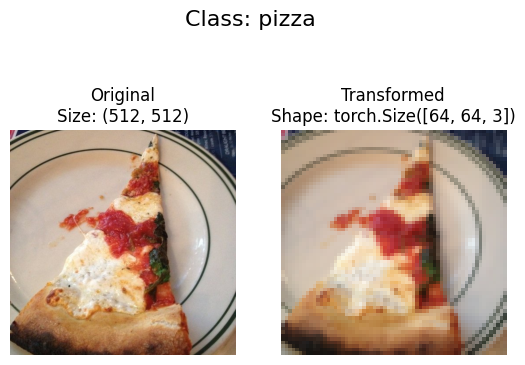

In [15]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  """
  Selects rrandom images from a path of images and loads/transfoms them then plots
  the original and the transformed version
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k = n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      #Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0)  #going from (C, H, W) for (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis('off')

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)
